# ReAct Agent

In this notebook we will build a [ReAct](https://react-lm.github.io/) agent, a general tool-calling agent architecture that:
- lets the model call specific tools
- passes the tool output back to the model
- lets the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools. 

![ReAct architecture](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F06f2cf46-df40-48f9-a798-931222b0f70a_590x592.png)

The complete implementation of the ReAct agent can be found on `src/hackathon/agents/react/agent.py`

In [1]:
# load the environment variables
import os
from dotenv import load_dotenv
load_dotenv(verbose=True)

True

## State

In [2]:
from typing_extensions import TypedDict
from typing import Annotated, Any
from operator import add
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# define the state
class ReActState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]  # same as in langgraph.graph.MessagesState

## Tools

Here we define the tools using the `@tool` decorator. We set `response_format="content_and_artifact"` to save the artifacts of a tool's execution that we want to make accessible to downstream components of the graph or backend APIs. "For example if a tool returns a custom object, a dataframe or an image, we may want to pass some metadata about this output to the model without passing the actual output to the model. At the same time, we may want to be able to access this full output elsewhere, for example in downstream tools." ([see docs](https://python.langchain.com/docs/how_to/tool_artifacts/))

This way, we distinguish between the parts of the tool output meant for the model (this is the ToolMessage.content) and those parts which are meant for use outside the model (ToolMessage.artifact).

In [3]:
from langchain_core.tools import tool
from hackathon.config import llm, ModelProviders

@tool(response_format="content_and_artifact", parse_docstring=True)
def add(a: int, b: int) -> tuple[str, int]:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    result = a + b
    message = f"Adding {a} and {b} gives {result}"
    return message, result

@tool(response_format="content_and_artifact", parse_docstring=True)
def multiply(a: int, b: int) -> tuple[str, int]:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    result = a * b
    message = f"Multiplying {a} and {b} gives {result}"
    return message, result

@tool(response_format="content_and_artifact", parse_docstring=True)
def divide(a: int, b: int) -> tuple[str, float]:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    if b == 0:
        raise ValueError("Cannot divide by zero")
    result = a / b
    message = f"Dividing {a} by {b} gives {result}"
    return message, result

In [4]:
tools = [add, multiply, divide]

if os.getenv("MODEL_PROVIDER") == ModelProviders.OPENAI:
    # we set parallel tool calling to false as math generally is done sequentially
    bind_math_tools_kwargs = {"parallel_tool_calls": False}
else:
    # Ollama chat model does not support the parallel tool calling feature
    bind_math_tools_kwargs = {}

# Bind tools to the LLM
llm_with_tools = llm.bind_tools(tools, **bind_math_tools_kwargs)

## ReAct agent

### Nodes

[`ToolNode`](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.tool_node.ToolNode) is a useful shortcut if you want to create a node to execute tools.

The `ToolNode` is roughly analogous to:

```python
tools_by_name = {tool.name: tool for tool in tools}
def tool_node(state: dict):
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}
```

the [`tools_condition`](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.tool_node.tools_condition) is a simple router used to build the ReAct's conditional edge:
- If the latest message from assistant is a tool call -> tools_condition routes to `"tools"` (we need to make sure to name the tool node as `"tools"`)
- If the latest message from assistant is a not a tool call -> tools_condition routes to `END`

### Graph

In [5]:
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Nodes
def llm_node(state: ReActState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

tool_node = ToolNode(tools)

# Graph
react_builder = StateGraph(ReActState)

# Define nodes
react_builder.add_node("llm", llm_node)
react_builder.add_node("tools", tool_node)

# Define edges
react_builder.add_edge(START, "llm")
react_builder.add_conditional_edges("llm", tools_condition)  # routes to "tools" or "__end__"
react_builder.add_edge("tools", "llm")

# Compile the graph
react_graph = react_builder.compile()

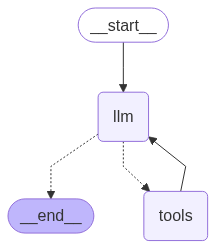

In [6]:
# Show Graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

### Run ReAct Agent

In [7]:
# Define the input
messages = [
    HumanMessage(content="Add 11 and 53. Multiply the output by 2. Then divide it by 16"),
]

# Run the graph
react_output = react_graph.invoke(input={"messages": messages})

In [8]:
# get messages and tool outputs
for m in react_output["messages"]:
    m.pretty_print()
    if isinstance(m, ToolMessage):
        print()
        print(f" --> Tool artifact: {m.artifact} (type: {type(m.artifact)})")

================================ Human Message =================================

Add 11 and 53. Multiply the output by 2. Then divide it by 16
================================== Ai Message ==================================
Tool Calls:
  add (call_rSHI6ZW1ETy4YXFI7f3QRyjY)
 Call ID: call_rSHI6ZW1ETy4YXFI7f3QRyjY
  Args:
    a: 11
    b: 53
================================= Tool Message =================================
Name: add

Adding 11 and 53 gives 64

 --> Tool artifact: 64 (type: <class 'int'>)
================================== Ai Message ==================================
Tool Calls:
  multiply (call_MZtbJwdrNGcMMa1aku3Hc1Mn)
 Call ID: call_MZtbJwdrNGcMMa1aku3Hc1Mn
  Args:
    a: 64
    b: 2
================================= Tool Message =================================
Name: multiply

Multiplying 64 and 2 gives 128

 --> Tool artifact: 128 (type: <class 'int'>)
================================== Ai Message ==================================
Tool Calls:
  divide (call_CMMhyRU

In [9]:
react_output

{'messages': [HumanMessage(content='Add 11 and 53. Multiply the output by 2. Then divide it by 16', additional_kwargs={}, response_metadata={}, id='cb48bba3-2b4a-48c9-ae48-d092bf5edf0b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rSHI6ZW1ETy4YXFI7f3QRyjY', 'function': {'arguments': '{"a":11,"b":53}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 145, 'total_tokens': 162, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'id': 'chatcmpl-BlkgfUlmJDSFL3BpoTJsiDkALMmNP', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--60894b5d-67d2-4d00-a8e1-f63deb2229c1-0', tool_calls=[{'name': 'add', 'args': {'a': 11, 'b': 53}

In [10]:
final_message = react_output["messages"][-1]
print(final_message.content)

Here are the calculations step by step:

1. 11 + 53 = 64
2. 64 × 2 = 128
3. 128 ÷ 16 = 8

The final result is 8.


## Explore Further

### Persistance

Langchain agents can have [two types of memory](https://langchain-ai.github.io/langgraph/how-tos/persistence/):

1. **Short-term (within-thread) memory (a.k.a. checkpointers)**: Chatbot can persist conversational history and / or allow interruptions in a chat session 
2. **Long-term (cross-thread) memory (a.k.a. stores)**: Chatbot can remember information about a specific user *across all chat sessions*